9.4 2장에서 제시된 물가상승률의 표본기간을 확장한 다음, 구조변화가 2번인 모형을 추정하고 그 결과를 제시하시오

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats.mstats import winsorize

In [2]:
data_path='./data/korea_cpi_crude_oil.csv'
data = pd.read_csv(data_path, index_col=0, parse_dates=True)

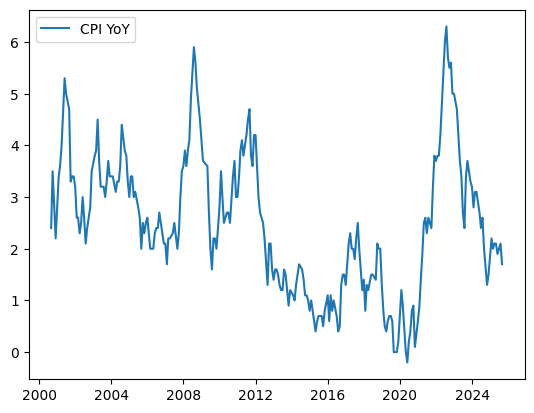

-0.2 6.3


In [3]:
import matplotlib.pyplot as plt
plt.plot(data.index, data['korea_cpi_yoy'], label='CPI YoY')
plt.legend()
plt.show()
print(data['korea_cpi_yoy'].min(), data['korea_cpi_yoy'].max())

In [4]:
y=data['korea_cpi_yoy'].iloc[1:]
x=data['korea_cpi_yoy'].shift(1).iloc[1:].to_frame()
x['const']=1
x.dropna(inplace=True)

In [20]:
from scipy.stats import invgamma, multivariate_normal, norm, beta

def sampling_beta(y:pd.Series, x:pd.DataFrame, state: pd.Series, sigma2_1: float, sigma2_2: float, beta_prior_mean: np.ndarray, beta_prior_var: np.ndarray):
    y1=y.loc[state[state==1].index]
    x1=x.loc[y1.index]

    y2=y.loc[state[state==2].index]
    x2=x.loc[y2.index]

    beta_var_inv=np.linalg.pinv(beta_prior_var)
    k=len(beta_prior_mean)

    # sampling beta1
    beta1_post_var=np.linalg.pinv(beta_var_inv + (x1.T @ x1)/sigma2_1)
    beta1_post_mean=beta1_post_var @ (beta_var_inv @ beta_prior_mean + (x1.T @ y1)/sigma2_1)
    beta1_sample=multivariate_normal.rvs(mean=beta1_post_mean, cov=beta1_post_var)

    # sampling beta2
    beta2_post_var=np.linalg.pinv(beta_var_inv + (x2.T @ x2)/sigma2_2)
    beta2_post_mean=beta2_post_var @ (beta_var_inv @ beta_prior_mean + (x2.T @ y2)/sigma2_2)
    beta2_sample=multivariate_normal.rvs(mean=beta2_post_mean, cov=beta2_post_var)
    return beta1_sample, beta2_sample, x1, x2, y1, y2

def sampling_sigma2(y2, y1, x2, x1, beta2, beta1, alpha_prior, beta_prior):
    res1=y1 - x1 @ beta1
    res2=y2 - x2 @ beta2

    # sampling sigma2_1, sigma2_2
    shape1=alpha_prior + len(res1)
    scale1=beta_prior + res1.T @ res1
    sigma2_1=invgamma.rvs(a=shape1/2, scale=scale1/2)

    shape2=alpha_prior + len(res2)
    scale2=beta_prior + res2.T @ res2
    sigma2_2=invgamma.rvs(a=shape2/2, scale=scale2/2)

    return sigma2_1, sigma2_2

def sampling_state(y, x, beta1, beta2, sigma2_1, sigma2_2, p11, p22):
    def get_filtered_prob(y, x, beta1, beta2, sigma2_1, sigma2_2, p11, p22):
        # get filtered probability by hamilton filter
        
        # initial state probability
        prob=np.zeros((2, 2))
        prob[0, 0]=p11
        prob[0, 1]=1-p11
        prob[1, 0]=1-p22 
        prob[1, 1]=p22

        prob_init=np.zeros(2)
        if p22 <1:
            prob_init[0]=(1-p22)/(2-p11-p22)
            prob_init[1]=1-prob_init[0]
        else:
            prob_init[0]=1
            prob_init[1]=0

        filtered_prob=pd.DataFrame(0.0, index=y.index, columns=[1, 2])
        filtered_prob.iloc[0, :]=prob_init
        for t in range(1, len(y)):
            y_t=y.iloc[t]
            x_t=x.iloc[t, :]

            # predicted probability P(S_t=j|Y_{t-1}, \theta
            pred_prob=np.zeros(2)
            pred_prob[0]=filtered_prob.iloc[t-1, 0]*prob[0, 0]+filtered_prob.iloc[t-1, 1]*prob[1, 0]
            pred_prob[1]=filtered_prob.iloc[t-1, 0]*prob[0, 1]+filtered_prob.iloc[t-1, 1]*prob[1, 1]

            # likelihood P(y_t |Y_{t-1}, \theta)
            like_prob=np.zeros(2)
            like_prob[0]=norm.pdf(y_t, loc=x_t @ beta1, scale=np.sqrt(sigma2_1))
            like_prob[1]=norm.pdf(y_t, loc=x_t @ beta2, scale=np.sqrt(sigma2_2))

            # update filtered probability
            filtered_prob.iloc[t, 0]=pred_prob[0]*like_prob[0]
            filtered_prob.iloc[t, 1]=pred_prob[1]*like_prob[1]
            filtered_prob.iloc[t, :]=filtered_prob.iloc[t, :]/filtered_prob.iloc[t, :].sum()

        return filtered_prob, prob
    
    def backward_sampling(filtered_prob, prob_matrix):
        # backward sampling using the filtered probability and transition probability matrix
        state = np.zeros(len(filtered_prob), dtype=int)
        for t in range(len(filtered_prob)-1, 0, -1):
            if t == len(filtered_prob)-1:
                state[t] = np.random.choice([1, 2], p=filtered_prob.iloc[t, :])
            else:
                before_state = state[t+1]
                cur_p=np.zeros(2)
                cur_p[0]=filtered_prob.iloc[t, 0]*prob_matrix[0, before_state-1]
                cur_p[1]=filtered_prob.iloc[t, 1]*prob_matrix[1, before_state-1]
                cur_p=cur_p/cur_p.sum()
                state[t] = np.random.choice([1, 2], p=cur_p)
        state[0]=1
        return state

    filtered_prob, prob_matrix=get_filtered_prob(y, x, beta1, beta2, sigma2_1, sigma2_2, p11, p22)

    state = backward_sampling(filtered_prob, prob_matrix)

    return state

def sampling_transition_prob(post_state, alpha_prior, beta_prior):
    def count_transition(states):
        count=np.zeros((2, 2))
        for t in range(1, len(states)):
            count[states[t-1]-1, states[t]-1]+=1
        return count

    transition_count=count_transition(post_state)
    p11_sample=beta.rvs(a=alpha_prior+transition_count[0, 0], b=beta_prior+transition_count[0, 1])
    return p11_sample
    

In [24]:
# set prior hyperparameters

# beta_prior
beta_mu=[0.5, 0.7]
beta_sigma=np.diag([0.09, 0.01])

# sigma prior
sigma_a=10
sigma_b=1
sigma2_beta_1=0.5*sigma_b/(0.5*sigma_a-1)
sigma2_beta_2=0.5*sigma_b/(0.5*sigma_a-1)

# state prior
p1_a=200
p1_b=4
states_prior=pd.Series(np.ones(len(y)), index=y.index)
states_prior.iloc[int(len(y)/2):]=2
p11=(p1_a)/(p1_a+p1_b)
p22=1

# sampling results
burn_in=1000
n_samples=5000
total_samples=burn_in+n_samples
state_samples=pd.DataFrame(np.zeros((total_samples, len(y))), columns=y.index)
change_points_cnt=pd.Series(np.zeros(len(y)), index=y.index)
beta_samples_1=pd.DataFrame(np.zeros((total_samples, 2)), columns=['const', 'crude_oil_yoy'])
beta_samples_2=pd.DataFrame(np.zeros((total_samples, 2)), columns=['const', 'crude_oil_yoy'])
sigma2_samples_1=pd.Series(np.zeros(total_samples))
sigma2_samples_2=pd.Series(np.zeros(total_samples))
p_samples_11=pd.Series(np.zeros(total_samples))

for i in tqdm(range(total_samples)):
    # step 1: sample beta1, beta2
    beta1, beta2, x1, x2, y1, y2=sampling_beta(y, x, states_prior, sigma2_beta_1, sigma2_beta_2, np.array(beta_mu), beta_sigma)
    beta_samples_1.iloc[i, :]=beta1
    beta_samples_2.iloc[i, :]=beta2

    # step 2: sample sigma2_1, sigma2_2
    sigma2_beta_1, sigma2_beta_2=sampling_sigma2(y2, y1, x2, x1, beta2, beta1, sigma_a, sigma_b)
    sigma2_samples_1.iloc[i]=sigma2_beta_1
    sigma2_samples_2.iloc[i]=sigma2_beta_2

    # step 3: sample states
    states_post=sampling_state(y, x, beta1, beta2, sigma2_beta_1, sigma2_beta_2, p11, p22)
    states_prior=pd.Series(states_post, index=y.index)
    state_samples.iloc[i, :]=states_post

    if i > burn_in:
        change_points_cnt+=states_prior.diff().abs().values

    # step 4: sample transition probability
    p11=sampling_transition_prob(states_post, p1_a, p1_b)
    p_samples_11.iloc[i]=p11

100%|██████████| 6000/6000 [07:13<00:00, 13.83it/s]


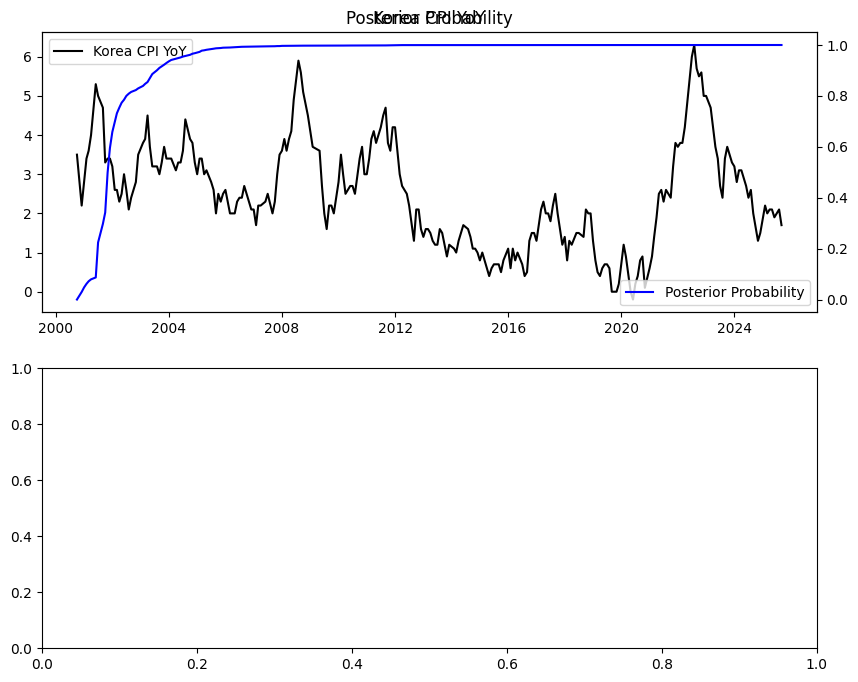

In [25]:
import matplotlib.pyplot as plt

fig, axes=plt.subplots(2, 1, figsize=(10, 8))
axes[0].plot(y.index, y, label='Korea CPI YoY', color='black')
axes[0].set_title('Korea CPI YoY')
axes[0].legend()
ax2=axes[0].twinx()
post_states=state_samples.iloc[burn_in:, :]
post_prob=post_states.mean()-1
ax2.plot(y.index, post_prob, label='Posterior Probability', color='blue')
ax2.set_title('Posterior Probability')
ax2.legend()